In [1]:
import os
os.chdir('../ssl_neuron/')

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3
%pylab inline
%load_ext autoreload
%autoreload 2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.manifold import TSNE

/home/fpei2/miniconda3/envs/bmed7610/lib/python3.8/site-packages/tqdm-4.64.1-py3.8.egg/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from ssl_neuron.datasets import AllenDataset
from ssl_neuron.utils import plot_neuron, plot_tsne, neighbors_to_adjacency, compute_eig_lapl
from ssl_neuron.graphdino import create_model

#### Load config

In [6]:
config = json.load(open('./ssl_neuron/configs/config.json'))

#### Load model + checkpoint

In [7]:
model = create_model(config)

In [8]:
state_dict = torch.load('./ssl_neuron/ckpts/ckpt.pt')

In [9]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
model.eval()
model.cuda();

#### Load dataset

In [11]:
dset = AllenDataset(config, mode='all')

430it [00:12, 34.06it/s] 


In [20]:
feat, neigh = dset.__getsingleitem__(0)

In [21]:
# feat, neigh = dset._augment(neigh, feat, [0])
neigh, adj_matrix, not_deleted, distances = dset._reduce_nodes(neigh, [0])
feat = feat[not_deleted]

In [22]:
feat.shape, len(neigh)

((200, 8), 200)

In [23]:
adj_matrix = neighbors_to_adjacency(neigh, list(neigh.keys()))
lapl = compute_eig_lapl(adj_matrix, pos_enc_dim=config['model']['pos_dim'])

#### Plot neuron

IndexError: index 4777 is out of bounds for axis 0 with size 200

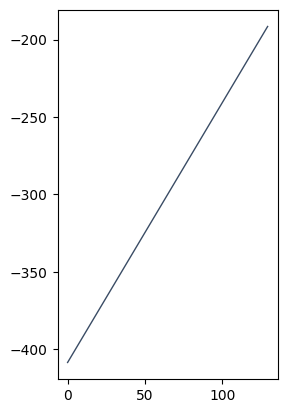

In [24]:
plot_neuron(neigh, feat)

#### Run inference

In [25]:
latents = np.zeros((dset.num_samples, config['model']['dim']))

for i in tqdm(range(dset.num_samples)):
    feat, neigh = dset.__getsingleitem__(i)
    neigh, adj_matrix, not_deleted, distances = dset._reduce_nodes(neigh, [0])
    feat = feat[not_deleted]
    adj = torch.from_numpy(neighbors_to_adjacency(neigh, list(neigh.keys()))).float().cuda()[None, ]
    lapl = compute_eig_lapl(adj_matrix, pos_enc_dim=config['model']['pos_dim']).float().cuda()[None, ]
    feat = torch.from_numpy(feat).float().cuda()[None, ]
    
    latents[i] = model.student_encoder.forward(feat, adj, lapl)[0].cpu().detach()


100%|██████████| 430/430 [03:41<00:00,  1.94it/s]


<ErrorbarContainer object of 3 artists>

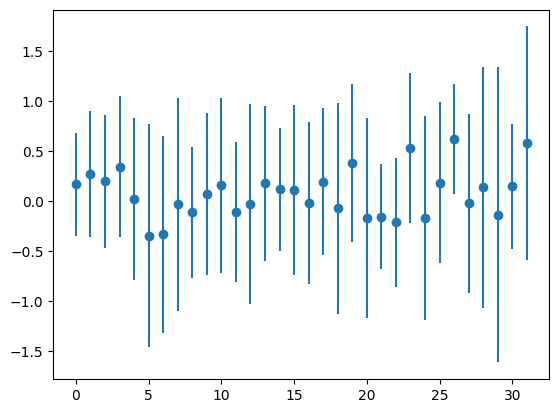

In [26]:
plt.scatter(np.arange(config['model']['dim']), latents.mean(axis=0))

plt.errorbar(np.arange(config['model']['dim']), latents.mean(axis=0), yerr = latents.std(axis=0), fmt='none')

In [27]:
colors = [list(sns.color_palette("mako", n_colors=10)[3])] + [list(sns.color_palette("mako", n_colors=10)[-2])]

In [28]:
z = TSNE(n_components=2, perplexity=30).fit_transform(latents)

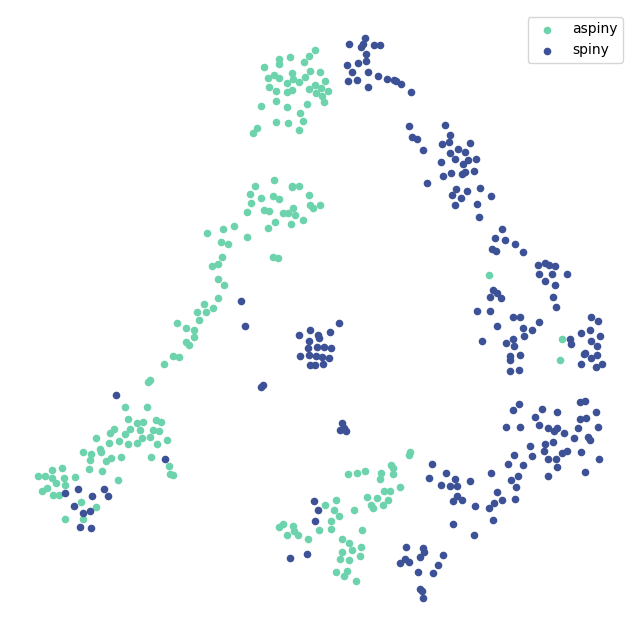

In [29]:
plot_tsne(z, np.concatenate([np.zeros(200, dtype=int), np.ones(230, dtype=int)]), targets=['aspiny', 'spiny'], colors=[colors[1], colors[0]])

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [34]:
labels = np.concatenate([np.zeros(200, dtype=int), np.ones(230, dtype=int)])

In [35]:
gscv = GridSearchCV(
    LogisticRegression(),
    {},
)
gscv.fit(latents, labels)

GridSearchCV(estimator=LogisticRegression(), param_grid={})

In [36]:
print(gscv.best_score_)

0.9395348837209301
